In [1]:
import pandas as pd
import geopandas as gpd
import geobr
import descartes
import zipfile
import os
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick

In [2]:
# Configurações do Pandas
pd.options.display.max_columns = 26

# Configurações do Matplotlib
style.use("seaborn-v0_8-pastel")

In [3]:
# Arrays e dicionários úteis

columns = ["NU_ANO","TP_NACIONALIDADE","TP_SEXO","TP_FAIXA_ETARIA","TP_COR_RACA","TP_ESTADO_CIVIL",
           "TP_ST_CONCLUSAO","TP_ESCOLA","IN_TREINEIRO","NO_MUNICIPIO_ESC","SG_UF_PROVA","TP_PRESENCA_CN",
           "TP_PRESENCA_CH","TP_PRESENCA_LC","TP_PRESENCA_MT","NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC",
           "NU_NOTA_MT","TP_STATUS_REDACAO","NU_NOTA_COMP1","NU_NOTA_COMP2","NU_NOTA_COMP3","NU_NOTA_COMP4",
           "NU_NOTA_COMP5","NU_NOTA_REDACAO"]

renamed_columns = ["Ano","Nacionalidade","Sexo","Idade","Cor","Estado_civil","Situacao_EM","Tipo_Escola",
                   "Treineiro","Municipio","Estado","Presenca_CN","Presenca_CH","Presenca_LC","Presenca_MT",
                   "Ciencias_Natureza","Ciencias_Humanas","Linguagens_Codigos","Matematica","Status_Redacao",
                   "Ortografia","Desenvolvimento","Informacoes","Organizacao","Proposta","Redacao"]

# Conseguindo a relação das categorias das colunas
faixa_etaria = {
    1: "Menor de 17 anos",
    2: "17 anos",
    3: "18 anos",
    4: "19 anos",
    5: "20 anos",
    6: "21 anos",
    7: "22 anos",
    8: "23 anos",
    9: "24 anos",
    10: "25 anos",
    11: "Entre 26 e 30 anos",
    12: "Entre 31 e 35 anos",
    13: "Entre 36 e 40 anos",
    14: "Entre 41 e 45 anos",
    15: "Entre 46 e 50 anos",
    16: "Entre 51 e 55 anos",
    17: "Entre 56 e 60 anos",
    18: "Entre 61 e 65 anos",
    19: "Entre 66 e 70 anos",
    20: "Maior de 70 anos"
}

estado_civil = {
    0: "Não informado",
    1: "Solteiro(a)",
    2: "Casado(a)/Mora com companheiro(a)",
    3: "Divorciado(a)/Desquitado(a)/Separado(a)",
    4: "Viúvo(a)"
}

etnia = {
    0: "Não declarado",
    1: "Branca",
    2: "Preta",
    3: "Parda",
    4: "Amarela",
    5: "Indígena",
    6: "Não dispõe da informação"
}

nacionalidade = {
    0: "Não informado",
    1: "Brasileiro(a)",
    2: "Brasileiro(a) Naturalizado(a)",
    3: "Estrangeiro(a)",
    4: "Brasileiro(a) Nato(a), nascido(a) no exterior"
}

situacao_ensino_medio = {
    1: "Já concluí o Ensino Médio",
    2: "Estou cursando e concluirei o Ensino Médio em 2022",
    3: "Estou cursando e concluirei o Ensino Médio após 2022",
    4: "Não concluí e não estou cursando o Ensino Médio"
}

tipo_instituicao = {
    1: "Não Respondeu",
    2: "Pública",
    3: "Privada"
}

treineiro = {
    1: "Sim",
    0: "Não"
}

situacao_redacao = {
    1: "Sem problemas",
    2: "Anulada",
    3: "Cópia Texto Motivador",
    4: "Em Branco",
    5:"Fere Direitos Humanos",
    6: "Fuga ao tema",
    7: "Não atendimento ao tipo textual",
    8: "Texto insuficiente",
    9: "Parte desconectada"
}

In [4]:
# Pegar o arquivo .csv dos microdados de dentro de todos os zips
zip_data = {
    "Zip Files":[],
    "Folder Data":  os.listdir("information")
}

for zippedArch in zip_data["Folder Data"]:
    with zipfile.ZipFile(f"information\{zippedArch}") as zippedData:
        for file in zippedData.namelist():
            if "microdados" in file.lower() and file.endswith(".csv"):
                zip_data["Zip Files"].append(file)

In [5]:
# Lambda pra ordenar os arquivos do mais antigo para o mais novo 2015 - 2022
zip_data["Zip Files"].sort(key = lambda x: x[22:-4])
zip_data["Folder Data"].sort(key = lambda x: x[16:-4])

In [6]:
enem_collection = []

# Criando o megadataframe filtrado
for i in range(len(zip_data["Zip Files"])):
    with zipfile.ZipFile(f"information\{zip_data['Folder Data'][i]}") as microdata:
        with microdata.open(zip_data["Zip Files"][i]) as csv:
            
            data = pd.read_csv(csv,encoding="ISO-8859-1",sep=";",usecols=columns)
            # Renomeando as colunas
            data.columns = renamed_columns
            # Removendo as linhas onde não temos notas
            data.dropna(subset=["Ciencias_Natureza",'Ciencias_Humanas',"Ciencias_Humanas","Matematica","Redacao"],inplace=True)
            data.reset_index(inplace=True,drop=True)
            # Adicionando no array pra criar o Dataframe completo posteriormente
            enem_collection.append(data)


In [7]:
# Criando o dataframe do Enem para fazer as análises
enem = pd.concat(enem_collection)

In [8]:
# Calculando a Nota Total de cada pessoa
enem['Nota Total'] = enem[['Ciencias_Natureza','Ciencias_Humanas','Matematica','Linguagens_Codigos','Redacao']].sum(axis=1)/5

## Qual o Ano que tivemos mais Treineiros?

In [9]:
# Buscando o percentual de Treineiros em cada ano
trein_year = pd.DataFrame(enem.groupby("Ano")['Treineiro'].value_counts(normalize=True)).reset_index()

In [10]:
# Pivotando a e ajustando a tabela pra ficar mais fácil de usar um gráfico horizontal
trein_year = trein_year.pivot_table('proportion', ['Ano'], 'Treineiro').reset_index()
trein_year.columns = ['Ano',"Não Treineiros","Treineiros"]

# Transformando os resultados em Porcentagem pra poder utilizar no gráfico a seguir
trein_year = trein_year.map(lambda x: x*100 if type(x) == float else x)

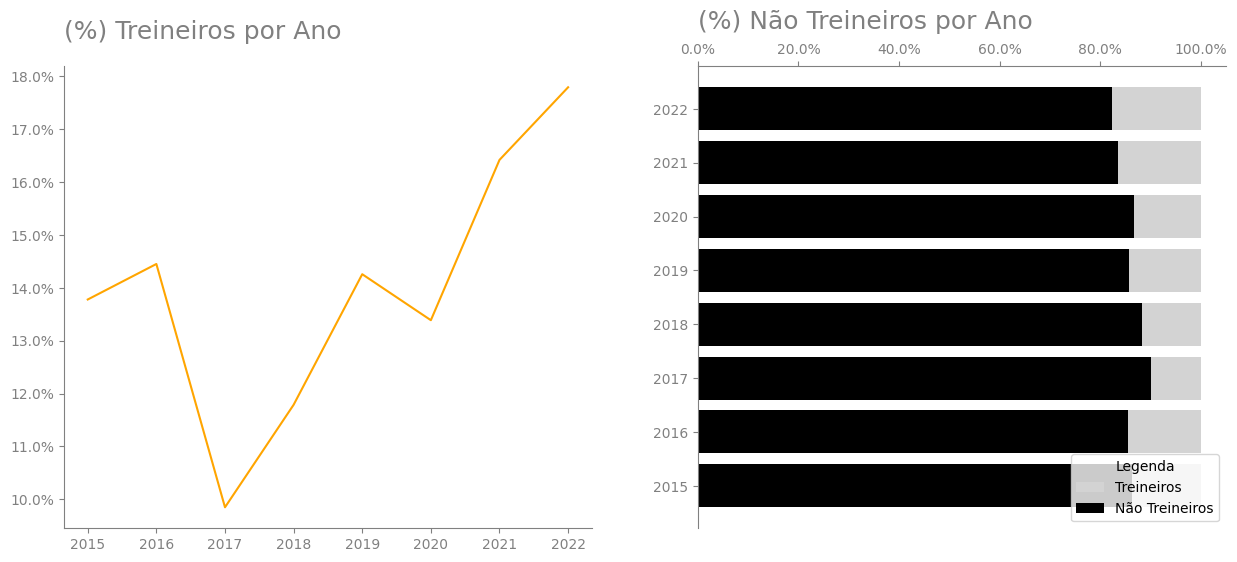

In [11]:
# Criando os gráficos Line Chart e Horizontal Bar
fig, axs = plt.subplots(1,2,figsize=(15,6))

# Criando o Line Chart pra visualizar o crescimento de Treineiros ao longo dos anos
axs[0].plot(trein_year['Ano'],trein_year['Treineiros'],color='orange')
axs[0].yaxis.set_major_formatter(StrMethodFormatter('{x}%'))
axs[0].set_title("(%) Treineiros por Ano",loc='left',color='gray',pad=20,size=18)
# Removendo as bordas do gráfico
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_color("gray")
axs[0].spines['left'].set_color("gray")
axs[0].tick_params(axis='x', colors='gray')
axs[0].tick_params(axis='y', colors='gray')

# Criando o Horizontal Bar
b1 = plt.barh(trein_year['Ano'],trein_year["Não Treineiros"],color='black')
b2 = plt.barh(trein_year['Ano'],trein_year["Treineiros"],color='lightgray',left=trein_year["Não Treineiros"])

plt.title("(%) Não Treineiros por Ano",loc='left',color='gray',pad=10,size=18)
plt.legend([b2, b1], ["Treineiros", "Não Treineiros"], title="Legenda", loc="lower right")

# Configurando os Axis do gráfico pra obter uma visualização mais Limpa e Uniforme dos dados
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.gca().xaxis.set_ticks_position('top')
plt.tick_params(axis='x', colors='gray')
plt.tick_params(axis='y', colors='gray')
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_color("gray")
plt.gca().spines['left'].set_color("gray")

plt.savefig('graphs/Treineiros_byYear.png', transparent=True, dpi=600)

## Quais os erros mais cometidos na redação ao longo dos anos?

In [12]:
errors_commited = pd.DataFrame(enem.loc[enem['Status_Redacao']!=1].groupby("Ano")['Status_Redacao'].value_counts(normalize=True)).reset_index()

# Relacionando os valores com o dicionário de Situação criado anteriormente
errors_commited['Status_Redacao'] = errors_commited['Status_Redacao'].map(situacao_redacao)

# Pegando quais os Erros que mais apareciam pra usar no gráfico
common_erros = errors_commited.pivot_table('proportion', ['Ano'], 'Status_Redacao').reset_index().set_index("Ano").idxmax('columns').unique()

In [13]:
# Pivotando a tabela pra ter um manuseio melhor
errors_commited = errors_commited.pivot_table('proportion', ['Ano'], 'Status_Redacao').reset_index().set_index("Ano")
# Tratando os NaN da tabela
errors_commited.fillna(0,inplace=True)
# Transformando em porcentagem
errors_commited = errors_commited.map(lambda x: x*100)

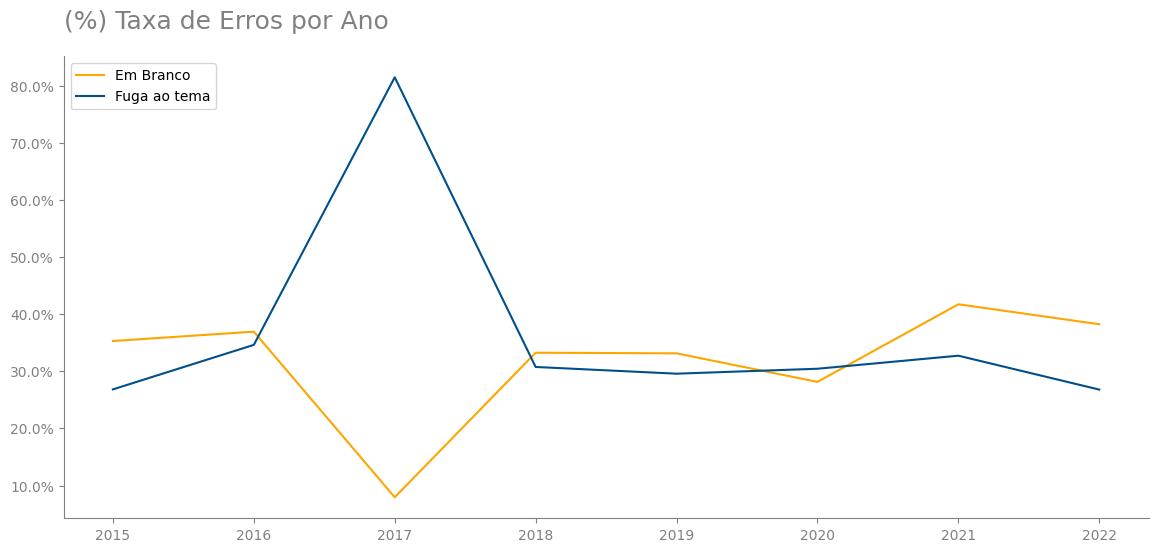

In [14]:
# Criando o Line Chart pra visualizar a porcentagem desses Erros ao longo do tempo
plt.figure(figsize=(14,6))
plt.title("(%) Taxa de Erros por Ano",loc='left',color='gray',pad=20,size=18)
plt.gca().set_prop_cycle(plt.cycler('color',["orange","#004F8B"]))

plt.plot(errors_commited.index,errors_commited[common_erros])

# Formatando os Axis do gráfico pra melhor visualização
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x}%'))
plt.legend(errors_commited[common_erros],loc='upper left')
plt.tick_params(axis='y', colors='gray')
plt.tick_params(axis='x', colors='gray')
plt.gca().spines['left'].set_color("gray")
plt.gca().spines['bottom'].set_color("gray")

# Removendo as bordas do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('graphs/common_erros.png', transparent=True, dpi=600)

## Qual os Estados com maiores notas (800+)
#### Nessa parte tive que refazer pois em teoria com esses calculos eu consigo avaliar por qualidade e não por quantidade nos estados:

##### ! O estado pode ter poucas pessoas, mas caso essas poucas pessoas tiveram um alto desempenho ele será um estado forte

In [15]:
# Filtrando os alunos por nota 800+ com uma coluna auxiliar
enem['Great_student'] = enem['Nota Total'].apply(lambda x: "Great" if x >= 800 else "Bad")

In [16]:
# Conseguindo os valores como porcentagem e dropando a coluna auxiliar
brazil_grades = pd.DataFrame(enem.groupby('Estado')['Great_student'].value_counts(normalize=True)).reset_index()
enem.drop("Great_student",axis=1,inplace=True)

In [17]:
# Pivotando a tabela e organizando os dados obtidos
brazil_grades = brazil_grades.pivot_table('proportion', ['Estado'], 'Great_student').reset_index()
brazil_grades = brazil_grades[['Estado',"Great"]]
# Elevando pra ficar em porcentagem de fato
brazil_grades = brazil_grades.map(lambda x: x*100 if type(x) == float else x)

In [18]:
# Criando o mapa do Brasil com geobr e descartes
brazil = geobr.read_country(year=2020)
# Conseguindo os valores geográficos de cada estado para relacionar com os valores obtidos dos microdados
brazil_grades = brazil.merge(brazil_grades[["Great","Estado"]],left_on="abbrev_state",right_on="Estado").drop("Estado",axis=1).sort_values("Great",ascending=False)

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:386: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  data[:] = [getattr(geom, op, None) for geom in left.data]
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
 

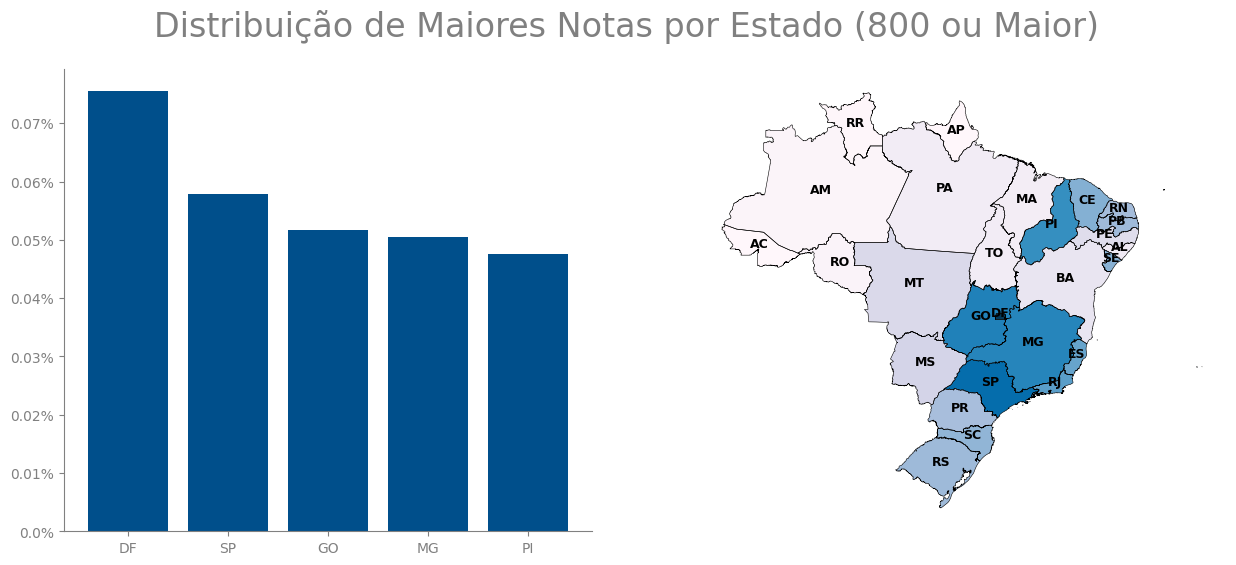

In [19]:
# Passei esse axs[0] porque queria deixar o mapa do lado direito, tentei de varias maneiras essa foi a unica que consegui
fig, (hobar,axs[0]) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle("Distribuição de Maiores Notas por Estado (800 ou Maior)",fontsize=24,color='gray')

# Criando um Bar Chart pra visualizarem melhor a relação dos Estados
hobar.bar(brazil_grades['abbrev_state'].head(),brazil_grades["Great"].head(),color='#004F8B')

# Configurando os Axis do gráfico pra obter uma visualização mais Limpa e Uniforme dos dados
hobar.yaxis.set_major_formatter(StrMethodFormatter('{x}%'))
hobar.tick_params(axis='x', colors='gray')
hobar.tick_params(axis='y', colors='gray')
hobar.spines['right'].set_visible(False)
hobar.spines['top'].set_visible(False)
hobar.spines['left'].set_color("gray")
hobar.spines['bottom'].set_color("gray")

# Criando o Heatmap Geográfico baseado no valor das notas do Enem por Estado

# Removendo o frame em volta do mapa pra melhorar a visualização
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

# Lambda pra adicionar a sigla dos estados no mapa e facilitar a identificação
brazil_grades.apply(lambda x: axs[0].annotate(text=x['abbrev_state'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, weight='bold'),axis=1)
brazil_grades.boundary.plot(ax=axs[0], color='Black', linewidth=.4)
brazil_grades.plot(column="Great",ax=axs[0], cmap='PuBu')

plt.savefig('graphs/Geographic_Grades.png', transparent=True, dpi=600)

## Qual a Distribuição de Idades nos ultimos 4 anos?

In [20]:
# Agrupando por ano pra construir as informações necesssárias
age_distribution = pd.DataFrame(enem.loc[enem.Idade!=0].groupby("Ano").Idade.value_counts(normalize=True)).reset_index()

In [21]:
age_distribution

,Ano,Idade,proportion
0,2015,1.0,0.862925
1,2015,2.0,0.121082
2,2015,3.0,0.015993
3,2016,1.0,0.862582
4,2016,2.0,0.122476
5,2016,3.0,0.014942
6,2017,1.0,0.910867
7,2017,2.0,0.076979
8,2017,3.0,0.010893
9,2017,4.0,0.001262


In [22]:
# Mapeando e tratando os dados pra porcentagem
age_distribution.Idade = age_distribution.Idade.map(faixa_etaria)

In [23]:
# Pivotando os dados pra ter uma melhor organização e pegando os 4 últimos anos de ENEM
age_distribution = age_distribution.pivot_table('proportion', ['Ano'], 'Idade').reset_index().sort_values("Ano",ascending=False).head(4)

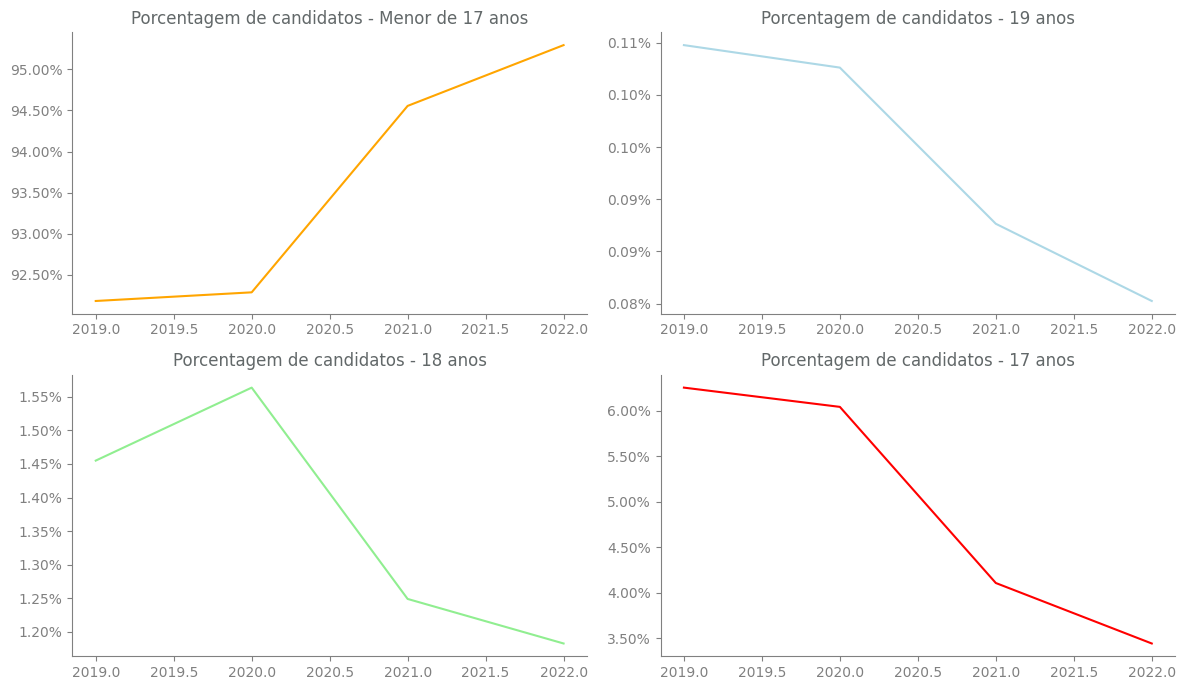

In [24]:
# Criando um gráfico pra avaliar a porcentagem de cada idade presente nos Anos
fig, axs = plt.subplots(2,2,figsize=(12,7))

# Criando um array pra não reescrever a mesma coisa 4 vezes
matrix = [[0,0,'Menor de 17 anos','orange'],
          [0,1,'19 anos','lightblue'],
          [1,0,'18 anos','lightgreen'],
          [1,1,'17 anos','red']]

# Criando os gráficos usando o array
for axis_data in matrix:
    
    # Personalizando o gráfico
    axs[axis_data[0],axis_data[1]].tick_params(axis='x', colors='gray')
    axs[axis_data[0],axis_data[1]].tick_params(axis='y', colors='gray')
    axs[axis_data[0],axis_data[1]].spines['right'].set_visible(False)
    axs[axis_data[0],axis_data[1]].spines['top'].set_visible(False)
    axs[axis_data[0],axis_data[1]].spines['left'].set_color("gray")
    axs[axis_data[0],axis_data[1]].spines['bottom'].set_color("gray")
    
    axs[axis_data[0],axis_data[1]].set_title(f"Porcentagem de candidatos - {axis_data[2]}",color='#626869')
    axs[axis_data[0],axis_data[1]].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=2, symbol='%', is_latex=False))
    
    # Plotando de fato
    axs[axis_data[0],axis_data[1]].plot(age_distribution['Ano'],age_distribution[axis_data[2]], label = axis_data[2], color = axis_data[3])


fig.tight_layout()
plt.savefig('graphs/age_distribution.png', transparent=True, dpi=600)

## Qual foi a maior nota total e de redação na cidade de Vinhedo em cada ano?

In [25]:
vinhedo_grades = enem.loc[enem['Municipio']=='Vinhedo'].groupby("Ano")[["Nota Total","Redacao"]].max()

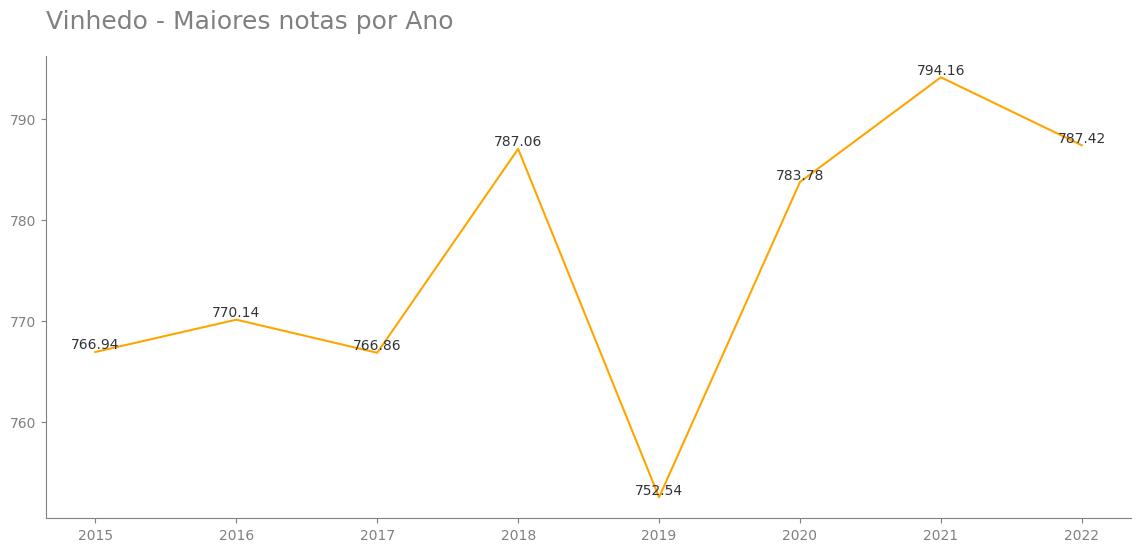

In [26]:
# Criando o Line Chart pra visualizar as maiores notas de cada ano
plt.figure(figsize=(14,6))
plt.title("Vinhedo - Maiores notas por Ano",loc='left',color='gray',pad=20,size=18)
plt.plot(vinhedo_grades.index,vinhedo_grades['Nota Total'],color="orange")

plt.tick_params(axis='y', colors='gray')
plt.tick_params(axis='x', colors='gray')
plt.gca().spines['left'].set_color("gray")
plt.gca().spines['bottom'].set_color("gray")

# Removendo as bordas do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adicionando os valores de Nota Total em cada ponto
for i, txt in enumerate(vinhedo_grades['Nota Total']):
    plt.text(vinhedo_grades.index[i], txt, f'{txt:.2f}', ha='center', va='bottom', color='#313435')
    
plt.savefig('graphs/vinhedo_grades_years.png', transparent=True, dpi=600)

## Qual foi a distribuição das notas em cada área do conhecimento?

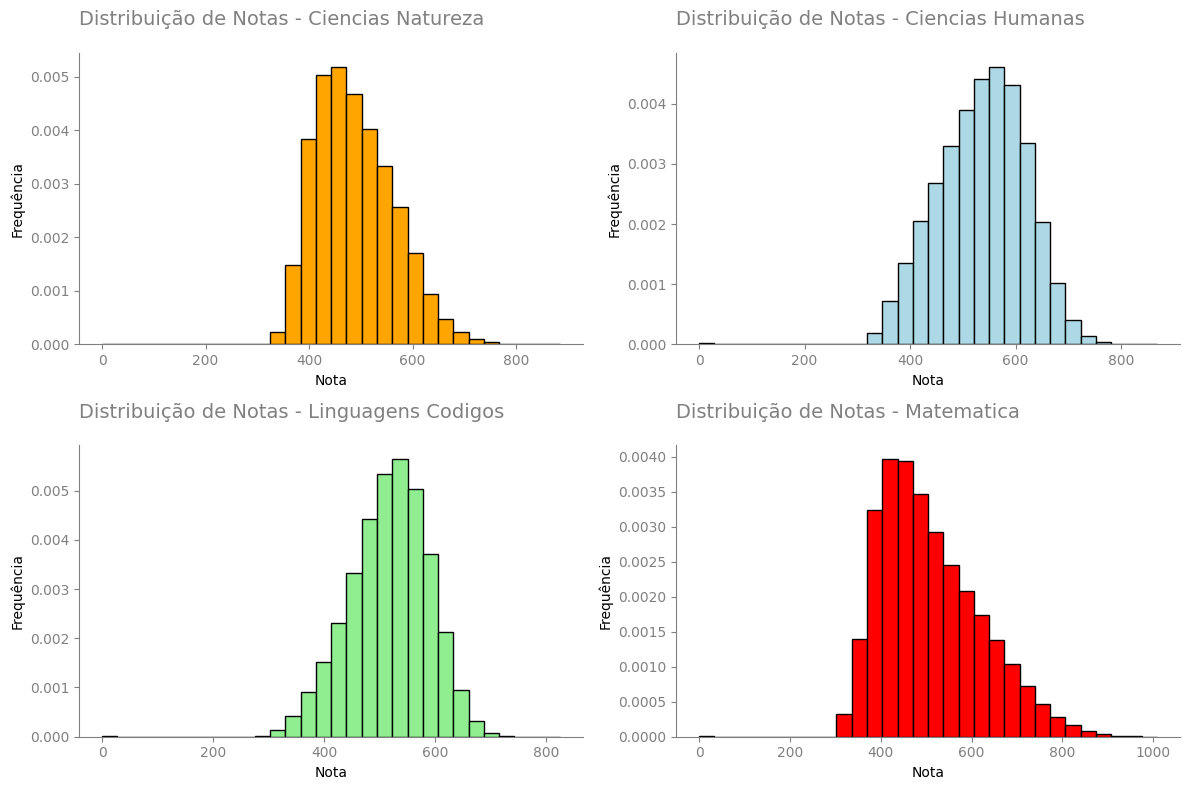

In [43]:
# Lista das áreas de conhecimento
areas_conhecimento = ['Ciencias_Natureza', 'Ciencias_Humanas', 'Linguagens_Codigos', 'Matematica']
colors = ['orange','lightblue','lightgreen','red']

# Configurando o tamanho da figura
plt.figure(figsize=(12, 8))

# Loop para criar subplots para cada área do conhecimento
for i, area in enumerate(areas_conhecimento, 1):
    plt.subplot(2, 2, i)
    plt.hist(enem[area], bins=30, color=colors[i-1], edgecolor='black', density=True)
    plt.title(f'Distribuição de Notas - {area.replace("_"," ")}',loc='left',color='gray',pad=20,size=14)
    plt.xlabel('Nota')
    plt.ylabel('Frequência')
    
    # Personalizando cada histograma
    plt.tick_params(axis='y', colors='gray')
    plt.tick_params(axis='x', colors='gray')
    plt.gca().spines['left'].set_color("gray")
    plt.gca().spines['bottom'].set_color("gray")

    # Removendo as bordas do gráfico
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Ajustando o layout
plt.tight_layout()
plt.savefig('graphs/knowledge_grades_distribution.png', transparent=True, dpi=600)

## Como podemos relacionar o tipo de Instituição do participante (Público X Privada) com o desempenho obtido?